# 4. Example: 4DVar Backprop DA using Reservoir Computing ML Model

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle

In [2]:
np_rng = np.random.default_rng(seed=50)

## A. Create Nature Run

In [3]:
train_size = 100000 
transient_size = 1000
test_size = 2000

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [5]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [6]:
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate Observations

In [7]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every 5th timestep
    random_location_count = 3,
    error_bias = 0.0, 
    error_sd = 1.0, 
    random_seed=94,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define and train model

In [8]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=6, 
    reservoir_dim=1600, 
    input_dim=6, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.07,
    spectral_radius = 0.1, 
    leak_rate=0.7,
    log_beta=-18.41)

In [9]:
# # Train: Takes ~5 minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('./l96_rc_weights.pkl')

In [10]:
# Shortcut: load the W_out weights from previous training
weights_path = './l96_rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

## D. Set up and run DA Cycler

In [11]:
sigma_obs=0.1
sigma_bg = 0.05
num_obs = 3

S = np.zeros((num_obs, nature_run.system_dim))
S[np.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 1)] = 1
H = S @ forecast_model.Wout.T
R = sigma_obs*np.identity(num_obs)
B = sigma_bg*np.identity(forecast_model.reservoir_dim)


In [12]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_transient.values
        + np.random.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=0.05))[-1], nr_transient.values[-1])

In [13]:
num_iters_per_cycle=3

In [14]:
dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=1e-5,
    num_iters=num_iters_per_cycle,
    model_obj=forecast_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )


Run the cycler

In [15]:
cur_tstep = 0

r0_sv = dab.vector.StateVector(
    values=r0_original,
    store_as_jax=True)

out_statevec = dc.cycle(
    input_state = r0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    analysis_window=0.1,
    timesteps=198,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=0.05)

[[  59.35725817   58.70365978   58.08689714]
 [  68.31109272   57.58465134   55.7514081 ]
 [  43.88056427   41.59760044   40.51307788]
 [  80.0671997    70.37552583   65.33585603]
 [  31.11832058   27.39369875   26.4545937 ]
 [  32.74466227   15.45316604   12.99035905]
 [  33.82314106   32.22437622   31.62004662]
 [ 240.23001715  179.00685066  165.06493225]
 [ 204.44282127  190.28706951  187.78249829]
 [ 190.13971341  118.50411968  102.50295669]
 [  69.95874919   68.66278453   67.39207915]
 [  78.1511897    65.33439317   62.04350618]
 [  44.27559841   43.8101003    43.45486238]
 [  40.66180063   40.12806021   39.7535364 ]
 [  42.97906965   40.49305993   38.51908381]
 [  73.53702601   72.33750892   71.32431072]
 [  48.32870703   43.99187448   41.7633779 ]
 [ 359.59567823  110.0129442    56.82428138]
 [  75.41078859   24.61360074   18.62908693]
 [ 113.80225973  111.1797654   110.05374501]
 [ 120.04767714  102.7791598    98.56633586]
 [  69.76191846   59.01037382   57.38598945]
 [  52.972

In [16]:
analyses_stacked = forecast_model.readout(out_statevec.values)

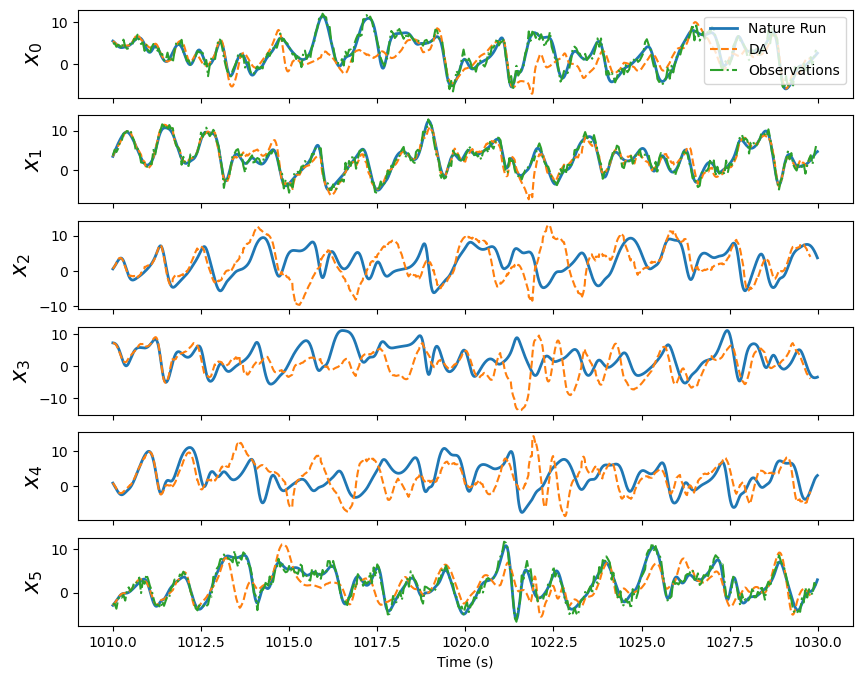

In [17]:
# Plot them all
i = 0
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run', lw=2)
    ax.plot(nr_test.times[:analyses_stacked.shape[0]], analyses_stacked[:, j],
        label='DA', ls='--', lw=1.5)
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times, obs_vec_l96.values[:, i], label='Observations', lw=1.5, ls='-.')
        i += 1
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j ==0:
        ax.legend()
ax.set_xlabel('Time (s)')        
plt.show()